## Center of Rotation

Author: Tom Wang @[tomwym](https://github.com/tomwym)

This document describes 3 approaches to determine the center of rotation of a sphere from at least 4 points.

Consider four points: $\mathbf{P_1}, \mathbf{P_2}, \mathbf{P_3}, \mathbf{P_4}$. The goal is to extract the center of a sphere from these four points.

#### Analytical

The first method discussed will cover the analytical basics of determining the center of rotation of a sphere from four points.

First consider this problem in 2D. We know that if we have three points we can trace a circle through these points so that it is a perfect fit. Essentially, from the three points we can extract both the position of the center, but also the radius of the circle. If you can intuit this it's also easy to see why three points that are co-linear cannot give enough information to draw a circle: the radius would become infinity! 

Now extend this 2D example to 3D. To represent a 3 dimensional problem, we need to have at least four points. And just like how the three points cannot lie on a line in 2D, the four points cannot line on the same plane.

Now introducing the analytical solution:

$$
\begin{align*}
t_1 &= -(x_1^2 + y_1^2 + z_1^2) \\
t_2 &= -(x_2^2 + y_2^2 + z_2^2) \\
t_3 &= -(x_3^2 + y_3^2 + z_3^2) \\
t_4 &= -(x_4^2 + y_4^2 + z_4^2) \\
T &= \left\lvert\begin{matrix}
    x_1 & y_1 & z_1 & 1 \\
    x_2 & y_2 & z_2 & 1 \\
    x_3 & y_3 & z_3 & 1 \\
    x_4 & y_4 & z_4 & 1
    \end{matrix}\right\rvert \\

D &= \frac{1}{T} \left\lvert\begin{matrix}
    t_1 & y_1 & z_1 & 1 \\
    t_2 & y_2 & z_2 & 1 \\
    t_3 & y_3 & z_3 & 1 \\
    t_4 & y_4 & z_4 & 1
    \end{matrix}\right\rvert \:\:\:

E = \frac{1}{T} \left\lvert\begin{matrix}
    x_1 & t_1 & z_1 & 1 \\
    x_2 & t_2 & z_2 & 1 \\
    x_3 & t_3 & z_3 & 1 \\
    x_4 & t_4 & z_4 & 1
    \end{matrix}\right\rvert \\

F &= \frac{1}{T} \left\lvert\begin{matrix}
    x_1 & y_1 & t_1 & 1 \\
    x_2 & y_2 & t_2 & 1 \\
    x_3 & y_3 & t_3 & 1 \\
    x_4 & y_4 & t_4 & 1
    \end{matrix}\right\rvert \:\:\:

G = \frac{1}{T} \left\lvert\begin{matrix}
    x_1 & y_1 & z_1 & t_1 \\
    x_2 & y_2 & z_2 & t_2 \\
    x_3 & y_3 & z_3 & t_3 \\
    x_4 & y_4 & z_4 & t_4
    \end{matrix}\right\rvert
\end{align*}
$$

The center will be at $(-\frac{D}{2}, -\frac{E}{2}, -\frac{F}{2})$, and the radius is $\frac{1}{2}\sqrt{D^2 + E^2 + F^2 -4G}$

On paper this method seems to be viable, from a set of measurements a sliding window can be used to determine 4 points to run the calculation multiple times. The pseudocode of this implementation is shown below:

```
i = 0
cor = (0,0,0)
while (i+4 < container.size) {
    cor += getCOR(container[i], container[i+1],
                  container[i+2], container[i+4])
    i++
}
cor /= i
```


#### Noise

A glaring issue in this algorithm is the presence of statistical noise. Consider, the goal of the project: get the Hololens to recognize and track the spatial position of a target object. Essentially, we are trying to get the hololens to act as one large sensor.

Consider the normal sensor model where measurement $\tilde{\mathbf{z}} = \bar{\mathbf{z}} + \epsilon$, where $\tilde{\mathbf{z}}$ is the measurement, $\bar{\mathbf{z}}$ is the true value, and $\epsilon$ is some measurement noise. **Can we use this information to construct a more accurate measurement?**

One possible solution which takes advantage of this known statistical information and implement a Kalman filter to reduce some of the noise. A Kalman Filter is a statistical filter which uses the known system statistics to infer a more accurate prediction of some state. In this case, we can treat the center of rotation determined from the equation as a measurement in itself, this way, we treat the problem as a purely observation based state estimation.

A simple Kalman filter with purely an observation update step can be applied to simply filter the data. 

Consider a Kalman filter where the state is equivalent to the center of rotation, (x,y,z). The pseudocode may look something similar to that shown below:

```
typename KalmanFilter object;
while (i+4 < container.size):
    cor = getCOR(container[i], container[i+1],
                  container[i+2], container[i+4]);
    object.update(cor);

cor = object.state;
```

Implementing the Kalman filter did seem to improve the quality of the measurements, however the observation errors presented are much greater than what the Kalman filter is capable of, or should be expected to deal with.

##### More Kalman Filter details

The Kalman Filter [(wikipedia is a great resource for this)](https://en.wikipedia.org/wiki/Kalman_filter) can be considered a 'white box' as opposed to the black 'box systems' engineers typically deal with. This means that the behavior is relatively expected and the statistical behavior corresponds with the information given to it. Typically three values need to be given to the Kalman filter, the initial covariance $\mathbf{P}$, the process noise $\mathbf{w}$, and the observation noise $\mathbf{v}$. These values essentially tell the model how much to trust the observations vs modelling. Since there is no state model the process noise can be neglected. The initial covariance will also automatically modify with respect to the given inputs. So the only input in this problem is the observation noise $\mathbf{v}$. 

#### Regression Modelling

What the Kalman Filter attempts to solve is the unreliability within the COR algorithm itself. This model essentially uses 4 points at once to predict the COR and does this multiple times. To think about it differently, **can we use the entirety of the data at once**. It's possible that the more data used simultaneously the less the impact of the noise in each measurement will be. If there is a systematic source of noise it's possible that accumulating the measurements will cause pseudo-random diviations to cancel out. To achieve this, a system is designed to predict four parameters: (x,y,z,r).

Skipping ahead a couple of steps, it was realized that including the radius in the problem was not very productive. Regression could not find the radius simultaneously, but other measures have been taken to determine the radius.

Consider the equation of a sphere:

$$ (x-x_0)^2 + (y-y_0)^2 + (z-z_0)^2 = R^2 $$

This equation describes the surface of a sphere with radius $R$, centered at $ \mathbf{C} = (x_0, y_0, z_0)$

To predict the center $\mathbf{C}$ we can simply use a Gradient Descent [(wikipedia is great for math)](https://en.wikipedia.org/wiki/Gradient_descent) numerical method to predict the center. Essentially, if we know $m$ data points of $(x_i,y_i,z_i)$, we can construct a 'cost' function. Consider cost function $\mathbf{J}$:

$$
\begin{align*}
\mathbf{J}(\mathbf{C}) &= \sum^m_{i=1} J_i(\mathbf{C}) \\
where \\
J_1 &= (x_1-x_0)^2 + (y_1-y_0)^2 + (z_1-z_0)^2 \\
J_2 &= (x_2-x_0)^2 + (y_2-y_0)^2 + (z_2-z_0)^2 \\
\vdots \\
J_m &= (x_m-x_0)^2 + (y_m-y_0)^2 + (z_m-z_0)^2 \\
\end{align*}
$$

This expression essentially evaluates the distance from the true center for any guess of $\mathbf{C}$. 

To then arrive at a solution for $\mathbf{C}$, we can use Gradient Descent. This algorithm is essentially the most intuitive optimization algorithm. At each step, we evaluate gradient of the cost function; the gradient represents the direction and magnitude of the greatest change of a function. we simply subtract the gradient multiplied by some acceleration factor $\gamma$ (gamma) from the current guess.

Consider the simple implementation of 2D gradient descent in finding (x,y,R) in the rest of the notebook.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

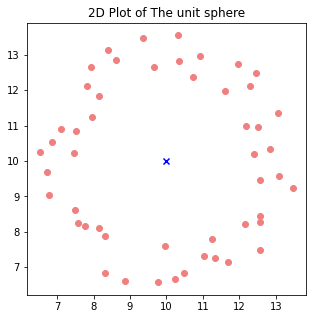

In [29]:
def GenerateError(lower, upper, m):
    return (upper-lower) * np.random.rand(m) + lower

# geometry
x0, y0, radius = 10, 10, 3
m = 50
e_upper, e_lower = radius/5, -radius/5

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
tlist = np.linspace(0, 2*np.pi, m)
xlist = radius*np.cos(tlist) + x0 + GenerateError(e_lower, e_upper, m)
ylist = radius*np.sin(tlist) + y0 + GenerateError(e_lower, e_upper, m)
# container for the simulated data
vecList = np.transpose(np.array([xlist,ylist]))
ax.scatter(xlist, ylist, color="lightcoral")
ax.scatter(x0, y0, marker='x', color='b')
plt.title('2D Plot of The unit sphere')
plt.show()


In [30]:
def Cost2D(vecList, parameters):
    x0 = parameters[0]
    y0 = parameters[1]
    J = 0
    for row in vecList:
        x_ = row[0]
        y_ = row[1]
        J += (x_-x0)**2 + (y_-y0)**2 
    return abs(J)

def Gradient2D(vecList, parameters):
    x0 = parameters[0]
    y0 = parameters[1]
    Jx = 0
    Jy = 0
    for row in vecList:
        Jx += 2*(x0-row[0])
        Jy += 2*(y0-row[1])
    grad = np.array([Jx, Jy])
    return grad

X = np.array([1,1])
gamma = 0.005
i = 0
while(abs(Cost2D(vecList, X)) > 0.5 and i<100):
    X = X-gamma*Gradient2D(vecList, X)
    #print(Gradient(vecList, X))
    i += 1
print("predicted center: ", X)
print("predicted radius: ", np.average(np.linalg.norm(vecList-X, axis=1)))

predicted center:  [10.03214218  9.9741568 ]
predicted radius:  3.0207587178048616
